In [1]:
import pandas as pd
from looper import Looper
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from models import CNN_Encoder, RNN_Decoder_concat, image_features_extract_model

In [2]:
looper = Looper(CNN_Encoder, RNN_Decoder_concat, image_features_extract_model)

Training with the following params:
VOCAB_SIZE : 5000
BATCH_SIZE : 32
BUFFER_SIZE : 5000
embedding_dim : 512
embedding_words : 300
units : 512
embedding_size : 5001
MAX_LENGTH : 20
TOKENIZER_FOLDER : ./tokenizer/
TOKENIZER_NAME : spbe_tokenizer.e
CHECKPOINT_FOLDER : saved_models
## Run set_params to change params ##


In [3]:
tokenizer = looper.load_tokenizer()

loading from ./tokenizer/spbe_tokenizer.e


In [4]:
looper.params

{'VOCAB_SIZE': 5000,
 'BATCH_SIZE': 32,
 'BUFFER_SIZE': 5000,
 'embedding_dim': 512,
 'embedding_words': 300,
 'units': 512,
 'embedding_size': 5001,
 'MAX_LENGTH': 20,
 'TOKENIZER_FOLDER': './tokenizer/',
 'TOKENIZER_NAME': 'spbe_tokenizer.e',
 'CHECKPOINT_FOLDER': 'saved_models'}

In [7]:
# CHANGE PARAMS

params = {'VOCAB_SIZE': 5000,
 'BATCH_SIZE': 64,
 'BUFFER_SIZE': 5000,
 'embedding_dim': 256,
 'embedding_words': 100,
 'units': 512,
 'embedding_size': 5001,
 'MAX_LENGTH': 20,
 'TOKENIZER_FOLDER': './tokenizer/',
 'TOKENIZER_NAME': 'spbe_tokenizer.e',
 'CHECKPOINT_FOLDER': './checkpoint_dis/512_embed_256_units_new_aug_vgg248_100'}

params = looper.set_params(params)

Training with the following params:
VOCAB_SIZE : 5000
BATCH_SIZE : 64
BUFFER_SIZE : 5000
embedding_dim : 256
embedding_words : 100
units : 512
embedding_size : 5001
MAX_LENGTH : 20
TOKENIZER_FOLDER : ./tokenizer/
TOKENIZER_NAME : spbe_tokenizer.e
CHECKPOINT_FOLDER : ./checkpoint_dis/512_embed_256_units_new_aug_vgg248_100
## Run set_params to change params ##


In [8]:
looper.load_last_checkpoint()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f52d45ca4a8>]],
      dtype=object)

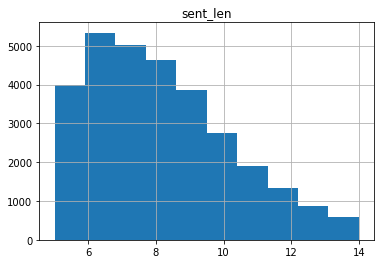

In [9]:
data = pd.read_csv('val.csv')
captions_val = data.title.to_list()
images_val = data.paths.to_list()

data = pd.read_csv('train.csv')
data['captions'] =  data['captions'].astype(str)
data['sent_len'] = data['captions'].apply(lambda r: len(r.split(' ')))
data = data[(data['sent_len']<20) & (data['sent_len']>4)]
captions_train = data.title.to_list()
images_train = data.paths.to_list()
data.hist('sent_len')

In [10]:
dataset_val = looper.make_dataset(images_val,captions_val)

max title len 20
len titles: 2375,len images: 2375
captions vector shape (2375, 20)
NOT using augmentations in loader


In [11]:
dataset_train = looper.make_dataset(images_train, captions_train, loader_type='aug')

max title len 20
len titles: 29254,len images: 29254
captions vector shape (29254, 20)
Using augmentations in loader


In [12]:
looper.train(dataset_train, dataset_val, 30, save_n=3)

Epoch 1 Batch 0 Loss 1.0168
Epoch 1 Batch 100 Loss 0.5563
Epoch 1 Batch 200 Loss 0.4574
Epoch 1 Batch 300 Loss 0.4686
Epoch 1 Batch 400 Loss 0.4750
precision at | val: 0.1595982124930934, train: 0.18756823144104803, train loss: 0.05417921241193879
Epoch 1 Loss 0.529565
Time taken for 1 epoch 266.0980520248413 sec

Epoch 2 Batch 0 Loss 0.4354
Epoch 2 Batch 100 Loss 0.4780
Epoch 2 Batch 200 Loss 0.4483
Epoch 2 Batch 300 Loss 0.4737
Epoch 2 Batch 400 Loss 0.4269
Epoch 2 Loss 0.469720
Time taken for 1 epoch 104.15654110908508 sec

Epoch 3 Batch 0 Loss 0.4495
Epoch 3 Batch 100 Loss 0.4218
Epoch 3 Batch 200 Loss 0.4430
Epoch 3 Batch 300 Loss 0.4464
Epoch 3 Batch 400 Loss 0.4310
Epoch 3 Loss 0.452134
Time taken for 1 epoch 103.47918677330017 sec

Epoch 4 Batch 0 Loss 0.4398
Epoch 4 Batch 100 Loss 0.4193
Epoch 4 Batch 200 Loss 0.3996
Epoch 4 Batch 300 Loss 0.4227
Epoch 4 Batch 400 Loss 0.4057
precision at | val: 0.19296287235460782, train: 0.20756004366812228, train loss: 0.05512108032359827
E

NameError: name 'plot' is not defined

In [13]:
def plot_losses(plot):
    f, ax = plt.subplots(1,2, figsize=(12,4))
    
    ax[0].plot([i['epoch'] for i in plot], [i['val'] for i in plot], c = 'k', label='val pr')
    ax[0].plot([i['epoch'] for i in plot], [i['train'] for i in plot], c ='g', label='train pr')
    ax[1].plot([i['epoch'] for i in plot], [i['val_loss'] for i in plot], c = 'k', label='val loss')
    ax[1].plot([i['epoch'] for i in plot], [i['train_loss'] for i in plot], c ='g', label='train loss')
    ax[0].legend(loc="upper left")
    ax[1].legend(loc="upper left")

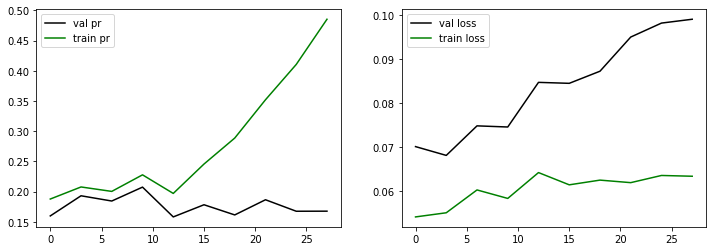

In [14]:
plot_losses(looper.plot)

# CHECK VAL

Real Caption: how to seduce the oatmeal bubble
0.5, how to get a cannibal , score 2
0.7, how to make your baby , score 2
0.9, how to think about. , score 2
1, how to know if you have a vegan , score 2


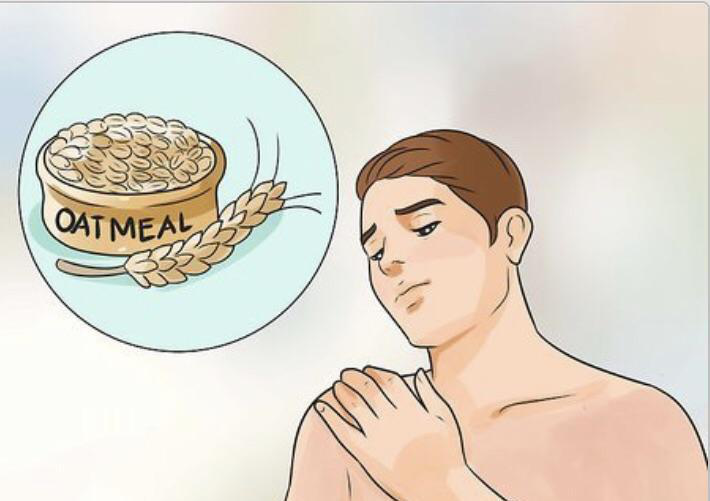

In [18]:
#### captions on the validation set

#img_name_val, cap_val
rid = np.random.randint(0, len(captions_val))
image = images_val[rid] #'./img.jpg' #
real_caption = captions_val[rid]
print ('Real Caption:', real_caption)

at_k = 5 # use 5 first words to compute score
seed = None #'▁cat'

for t in [0.5,0.7,0.9,1]:
    predicted_ids, a = looper.predict_one(image, t, argmax =2, seed=seed)
    real_cap = set(real_caption.split(' '))
    predicted_cap =  looper.tokenizer.decode(predicted_ids)
    score = len(real_cap.intersection(set(predicted_cap.split(' ')[:at_k]))) #/len(word)
    print(f"{t}, {predicted_cap}, score {score}")
Image.open(image)

0.5, how to take the night of the alphabet , score 3
0.7, how to treat a much , score 2
0.9, how to take the right mom in the ocean discreetly to a racist , score 3
1, how to pose for that nos , score 2


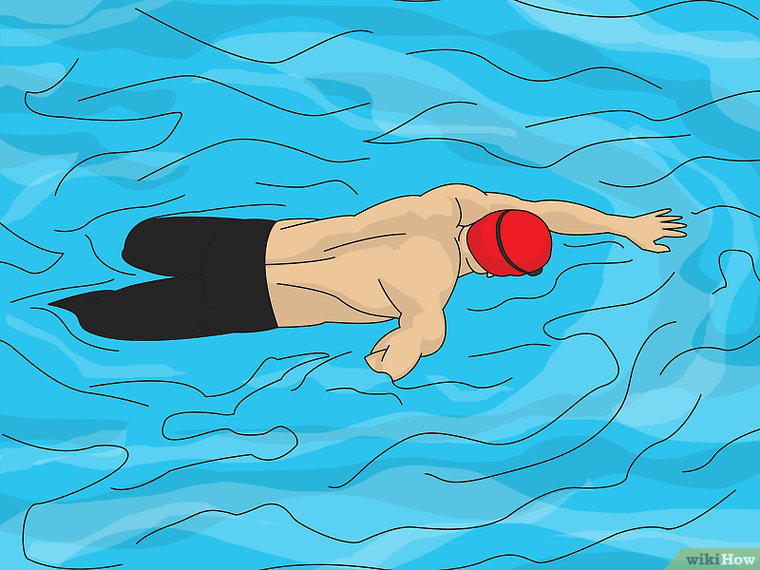

In [29]:
#### captions on the validation set

#img_name_val, cap_val
#rid = np.random.randint(0, len(captions_val))
image =  './img.jpg' #images_val[rid]
#real_caption = captions_val[rid]
#print ('Real Caption:', real_caption)

at_k = 5 # use 5 first words to compute score
seed = None #   '▁nice' 

for t in [0.5,0.7,0.9,1]:
    predicted_ids, a = looper.predict_one(image, t, argmax =2, seed=seed)
    real_cap = set(real_caption.split(' '))
    predicted_cap =  looper.tokenizer.decode(predicted_ids)
    score = len(real_cap.intersection(set(predicted_cap.split(' ')[:at_k]))) #/len(word)
    print(f"{t}, {predicted_cap}, score {score}")
Image.open(image)

### CHECK TRAIN

Real Caption: how to give yourself a tattoo
0.5, how to make your boyfriend , score 2
0.7, how to drink water , score 2
0.9, how to drink water to death in disney , score 2
1, how to give yourself a shower. , score 5


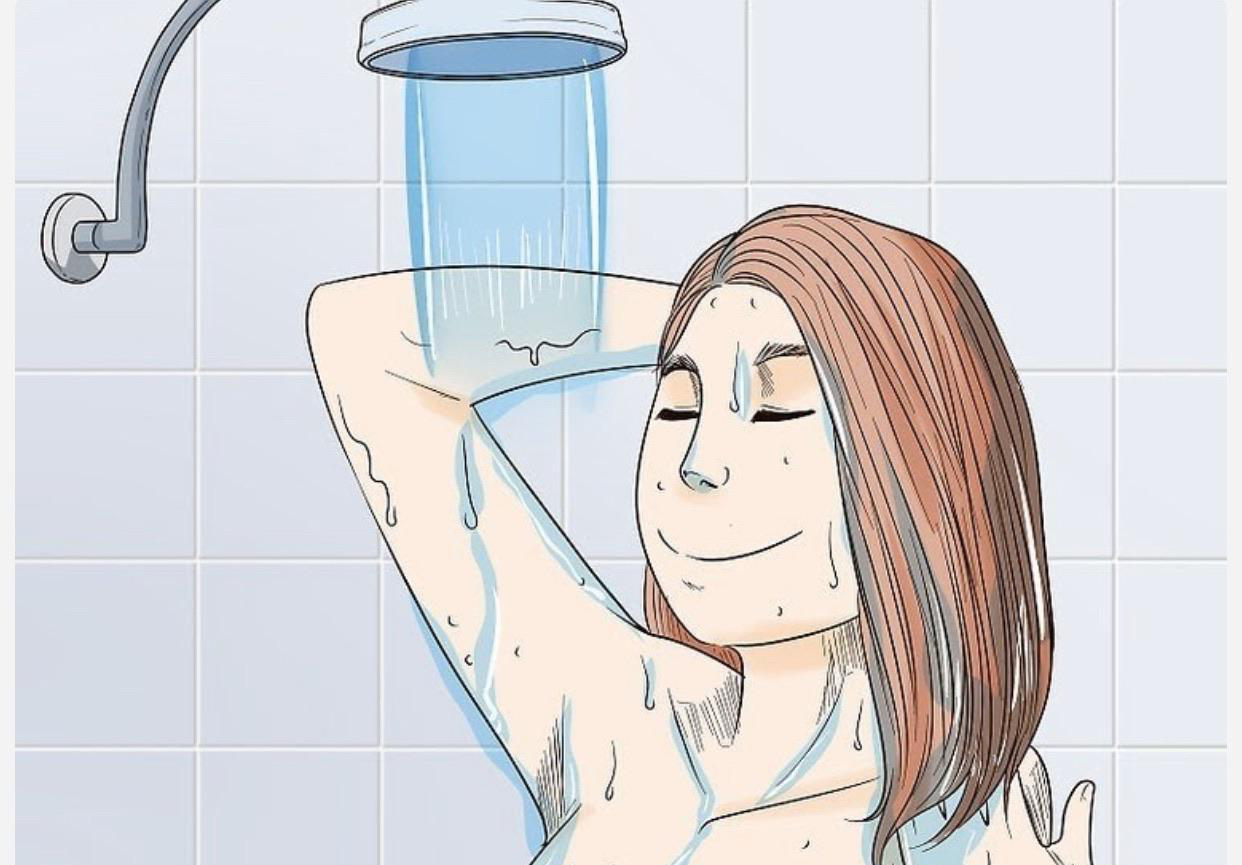

In [53]:
#### captions on the validation set

#img_name_val, cap_val
rid = np.random.randint(0, len(captions_train))
image = images_train[rid] #'./img.jpg' #
real_caption = captions_train[rid]
print ('Real Caption:', real_caption)

at_k = 5 # use 5 first words to compute score
seed = None #'▁cat'

for t in [0.5,0.7,0.9,1]:
    predicted_ids, a = looper.predict_one(image, t, argmax =2, seed=seed)
    real_cap = set(real_caption.split(' '))
    predicted_cap =  looper.tokenizer.decode(predicted_ids)
    score = len(real_cap.intersection(set(predicted_cap.split(' ')[:at_k]))) #/len(word)
    print(f"{t}, {predicted_cap}, score {score}")
Image.open(image)